In [55]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction


In [56]:
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2, 7, 8, 11, 13]:
        raise ValueError("'a' must be 2,7,8,11 or 13")
    U = QuantumCircuit(4)
    for _ in range(power):
        if a in [2, 13]:
            U.swap(0, 1)
            U.swap(1, 2)
            U.swap(2, 3)
        if a in [7, 8]:
            U.swap(2, 3)
            U.swap(1, 2)
            U.swap(0, 1)
        if a == 11:
            U.swap(1, 3)
            U.swap(0, 2)
        if a in [7, 11, 13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control()
    return c_U


In [57]:
n_count = 8  # number of counting qubits
a = 7


C:\Users\Manuel\AppData\Local\Programs\Python\Python38\lib\site-packages\qiskit\visualization\bloch.py:396: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  self.axes = Axes3D(self.fig, azim=self.view[0], elev=self.view[1])
C:\Users\Manuel\AppData\Local\Programs\Python\Python38\lib\site-packages\qiskit\visualization\bloch.py:68: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  x_s, y_s, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


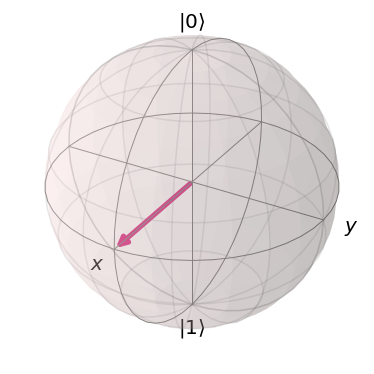

In [58]:
from qiskit_textbook.widgets import plot_bloch_vector_spherical
coords = [np.pi/2, 0, 1]  # [Theta, Phi, Radius]
plot_bloch_vector_spherical(coords)  # Bloch Vector with spherical coordinates


In [59]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc


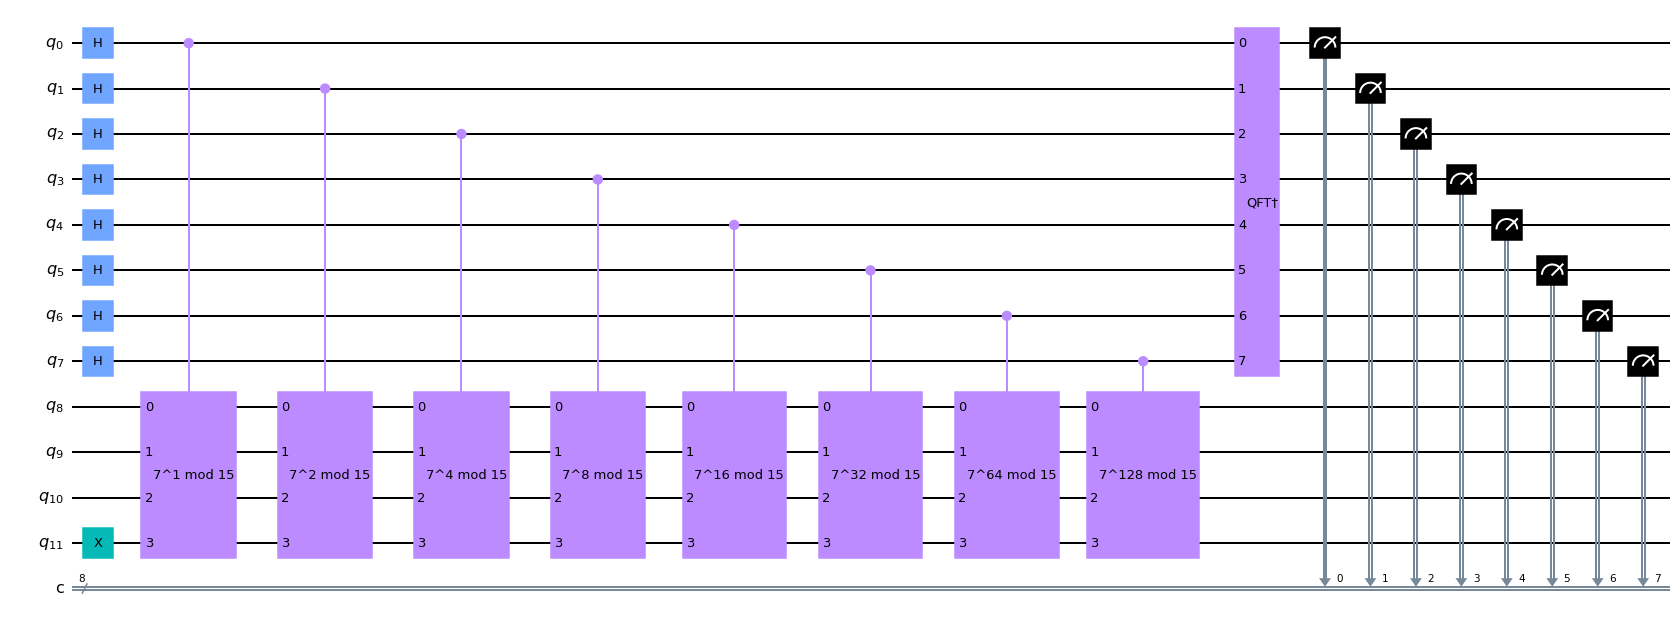

In [60]:
# Create QuantumCircuit with n_count counting qubits
# plus 4 qubits for U to act on
qc = QuantumCircuit(n_count + 4, n_count)

# Initialize counting qubits
# in state |+>
for q in range(n_count):
    qc.h(q)

# And auxiliary register in state |1>
qc.x(3+n_count)

# Do controlled-U operations
for q in range(n_count):
    qc.append(c_amod15(a, 2**q),
              [q] + [i+n_count for i in range(4)])

# Do inverse-QFT
qc.append(qft_dagger(n_count), range(n_count))

# Measure circuit
qc.measure(range(n_count), range(n_count))
qc.draw(output="mpl",fold=-1)  # -1 means 'do not fold'


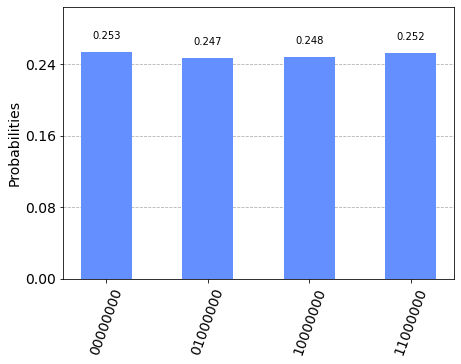

In [61]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, aer_sim)
qobj = assemble(t_qc)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)


In [62]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append(
        [phase, f"{frac.numerator}/{frac.denominator}", frac.denominator])
# Print as a table
headers = ["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)


   Phase Fraction  Guess for r
0   0.00      0/1            1
1   0.25      1/4            4
2   0.50      1/2            2
3   0.75      3/4            4


In [63]:
def a2jmodN(a, j, N):
    """Compute a^{2^j} (mod N) by repeated squaring"""
    for i in range(j):
        a = np.mod(a**2, N)
    return a


In [64]:
N = 15

7


In [65]:
np.random.seed(1)  # This is to make sure we get reproduceable results
a = randint(2, 15)
print(a)

from math import gcd  # greatest common divisor
gcd(a, N)


7

In [66]:
def qpe_amod15(a):
    n_count = 8
    qc = QuantumCircuit(4+n_count, n_count)
    for q in range(n_count):
        qc.h(q)     # Initialize counting qubits in state |+>
    qc.x(3+n_count)  # And auxiliary register in state |1>
    for q in range(n_count):  # Do controlled-U operations
        qc.append(c_amod15(a, 2**q),
                  [q] + [i+n_count for i in range(4)])
    qc.append(qft_dagger(n_count), range(n_count))  # Do inverse-QFT
    qc.measure(range(n_count), range(n_count))
    # Simulate Results
    aer_sim = Aer.get_backend('aer_simulator')
    # Setting memory=True below allows us to see a list of each sequential reading
    t_qc = transpile(qc, aer_sim)
    obj = assemble(t_qc, shots=1)
    result = aer_sim.run(qobj, memory=True).result()
    readings = result.get_memory()
    print("Register Reading: " + readings[0])
    phase = int(readings[0], 2)/(2**n_count)
    print("Corresponding Phase: %f" % phase)
    return phase


In [67]:
phase = qpe_amod15(a)  # Phase = s/r
# Denominator should (hopefully!) tell us r
Fraction(phase).limit_denominator(15)


Register Reading: 01000000
Corresponding Phase: 0.250000


Fraction(1, 4)

In [68]:
frac = Fraction(phase).limit_denominator(15)
s, r = frac.numerator, frac.denominator
print(r)


4


In [69]:
guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
print(guesses)


[8, 2]


In [70]:
a = 7
factor_found = False
attempt = 0
while not factor_found:
    attempt += 1
    print("\nAttempt %i:" % attempt)
    phase = qpe_amod15(a)  # Phase = s/r
    # Denominator should (hopefully!) tell us r
    frac = Fraction(phase).limit_denominator(N)
    r = frac.denominator
    print("Result: r = %i" % r)
    if phase != 0:
        # Guesses for factors are gcd(x^{r/2} ±1 , 15)
        guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
        print("Guessed Factors: %i and %i" % (guesses[0], guesses[1]))
        for guess in guesses:
            # Check to see if guess is a factor
            if guess not in [1, N] and (N % guess) == 0:
                print("*** Non-trivial factor found: %i ***" % guess)
                factor_found = True



Attempt 1:
Register Reading: 00000000
Corresponding Phase: 0.000000
Result: r = 1

Attempt 2:
Register Reading: 10000000
Corresponding Phase: 0.500000
Result: r = 2
Guessed Factors: 2 and 8
*** Non-trivial factor found: 2 ***
*** Non-trivial factor found: 8 ***
